# Project: Breast Cancer Classification

- TASK: Classify *benign* and *malignant* Invasive Ductal Carcinoma from histopathology images.
- MOTIVATION: Cancer is oftentimes physically noticeable in tissues and can be more easily treatable when detected early. Histology studies tissues, and Pathology stuidies diseases. Histopathology studies diseases in tissues. Pathologists examine images of tissue and come up with a verdict. Cancer kills up to 10M people every year(https://ourworldindata.org/cancer#cancer-is-one-of-the-leading-causes-of-death) and is one of the leading causesof death globally. Alongside lung, colon and stomach cancer, Breast cancer kills 700k people every year. Certain areas might not have the equipment or schooling necessary to make diagnosis a swift procedure, so patients might have to travel to get diagnosed, prolonging the period in which they can't receive treatment.
- In a way, Pathologists are performing classification task(*positive* or *negative*) based on patterns and occurrences in the images.

![](https://raw.githubusercontent.com/eulerianKnight/computer_vision/main/images/breast_cancer_1.PNG)






























## Domain Understanding

- Invasive Ductal Carcinoma (IDC) is most common Breast Cancer subtype which accounts for 80% of the cases.
- Tumors are bundles of cells that aren't supposed to bundle, and grow into solid lumps. Tumors can be benign and confined to a particular region and might not cause any problem Or they could grow and cause problems through their size. If a tumor starts growing  outside of the confounds of the group of cells-they become malignant.

## Import Packages

In [1]:
!pip install -q keras_tuner

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from glob import glob

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers
import keras_tuner as kt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Become One with the Data

- Dataset Paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4977982/
- Dataset Link: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images

In [3]:
# Authenticate Kaggle account
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!pip install -q kaggle

In [5]:
# Download the data from Kaggle
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.10G/3.10G [02:17<00:00, 25.4MB/s]
100% 3.10G/3.10G [02:17<00:00, 24.2MB/s]


In [6]:
# Unzip the data and remove the zip file
!unzip -q /content/breast-histopathology-images.zip -d breast-histopathology-images
!rm /content/breast-histopathology-images.zip

In [7]:
config = {
    'ROOT_PATH': '/content/breast-histopathology-images', 
    'IMG_SIZE': 200, 
    'BATCH_SIZE': 8
}

In [8]:
# Check the number of folders
data = os.listdir(config['ROOT_PATH'])
len(data)

280

In [9]:
# Check the first few folder name
# Each folder name is a patient ID
data[:10]

['13402',
 '9037',
 '14078',
 '10292',
 '12892',
 '12810',
 '12242',
 '8957',
 '13666',
 '16896']

In [10]:
# Check inside one of the folder
patient_13402 = os.listdir(os.path.join(config['ROOT_PATH'], '13402'))
patient_13402

['1', '0']

In [11]:
# Check inside each class folder
patient_13402_0 = os.listdir(os.path.join(config['ROOT_PATH'], '13402', '0'))
patient_13402_1 = os.listdir(os.path.join(config['ROOT_PATH'], '13402', '1'))
print(patient_13402_0[:5])
print(patient_13402_1[:5])

['13402_idx5_x351_y301_class0.png', '13402_idx5_x301_y1601_class0.png', '13402_idx5_x2401_y751_class0.png', '13402_idx5_x651_y401_class0.png', '13402_idx5_x301_y401_class0.png']
['13402_idx5_x1951_y651_class1.png', '13402_idx5_x2051_y751_class1.png', '13402_idx5_x2351_y1101_class1.png', '13402_idx5_x2301_y901_class1.png', '13402_idx5_x1751_y1201_class1.png']


## Machine Learning Workflow

- Preprocessing
- 

### Preprocessing

In [12]:
# Create a data directory list
data = glob(os.path.join(config['ROOT_PATH'], '*', '*', '*.png'), recursive=True)

In [13]:
print(f"Total number of images: {len(data)}")

Total number of images: 277524


In [14]:
# Create folders
if not os.path.exists('./histopathology_images_small/'):
    print('Creating folders for small dataset')
    os.mkdir('./histopathology_images_small/')

    os.mkdir('./histopathology_images_small/train/')
    os.mkdir('./histopathology_images_small/test/')
    os.mkdir('./histopathology_images_small/valid/')

    os.mkdir('./histopathology_images_small/train/0')
    os.mkdir('./histopathology_images_small/train/1')
    os.mkdir('./histopathology_images_small/test/0')
    os.mkdir('./histopathology_images_small/test/1')
    os.mkdir('./histopathology_images_small/valid/0')
    os.mkdir('./histopathology_images_small/valid/1')

Creating folders for small dataset


In [15]:
# Loop through
for batch_num, indices in enumerate(range(1000, int(len(data)/10), 1000), 1):

    x = []
    y = []

    # Load in indices: 'indices-1000' to 'indices'
    # 0:1000, 1000:2000, 2000:3000, etc
    for i in data[indices-1000:indices]:
        if i.endswith('.png'):
            label = i[-5]
            img = Image.open(i)
            img = np.asarray(img)
            x.append(img)
            y.append(label)

    # Create NumPy arrays from Python lists
    # x = np.array(x, dtype='float16')
    # y = np.array(y, dtype='float16')

    print(f"Processing batch {batch_num}, with images from {indices-1000} to {indices}")

    # Perform train test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.4, stratify=y)

    for index, img in enumerate(X_train):
        idc_class = y_train[index]
        path = os.path.join('histopathology_images_small', 'train', str(idc_class), f'batch_{batch_num}_sample_{index}.png')
        cv2.imwrite(path, img.astype('int'))

    for index, img in enumerate(X_test):
        if index%2 == 0:
            idc_class = y_test[index]
            path = os.path.join('histopathology_images_small', 'test', str(idc_class), f'batch_{batch_num}_sample_{index}.png')
            cv2.imwrite(path, img.astype('int'))

        else:
            idc_class = y_test[index]
            path = os.path.join('histopathology_images_small', 'valid', str(idc_class), f'batch_{batch_num}_sample_{index}.png')
            cv2.imwrite(path, img.astype('int'))

Processing batch 1, with images from 0 to 1000
Processing batch 2, with images from 1000 to 2000
Processing batch 3, with images from 2000 to 3000
Processing batch 4, with images from 3000 to 4000
Processing batch 5, with images from 4000 to 5000
Processing batch 6, with images from 5000 to 6000
Processing batch 7, with images from 6000 to 7000
Processing batch 8, with images from 7000 to 8000
Processing batch 9, with images from 8000 to 9000
Processing batch 10, with images from 9000 to 10000
Processing batch 11, with images from 10000 to 11000
Processing batch 12, with images from 11000 to 12000
Processing batch 13, with images from 12000 to 13000
Processing batch 14, with images from 13000 to 14000
Processing batch 15, with images from 14000 to 15000
Processing batch 16, with images from 15000 to 16000
Processing batch 17, with images from 16000 to 17000
Processing batch 18, with images from 17000 to 18000
Processing batch 19, with images from 18000 to 19000
Processing batch 20, wit

In [16]:
# Create paths
train_paths_small = glob(os.path.join('histopathology_images_small', 'train', '*', '*'), recursive=True)
test_paths_small = glob(os.path.join('histopathology_images_small', 'test', '*', '*'), recursive=True)
valid_paths_small = glob(os.path.join('histopathology_images_small', 'valid', '*', '*'), recursive=True)

In [17]:
# Get Labels
def get_labels(pathlist):
    labels = []
    for path in pathlist:
        labels.append(int(path.split(os.sep)[2]))
    labels = np.array(labels)
    return labels

train_labels_small = get_labels(train_paths_small)
test_labels_small = get_labels(test_paths_small)
valid_labels_small = get_labels(valid_paths_small)

In [18]:
print(len(train_paths_small))
print(len(test_paths_small))
print(len(valid_paths_small))

16200
5400
5400


In [19]:
# Check sample paths
train_paths_small[:5]

['histopathology_images_small/train/1/batch_16_sample_261.png',
 'histopathology_images_small/train/1/batch_5_sample_204.png',
 'histopathology_images_small/train/1/batch_3_sample_136.png',
 'histopathology_images_small/train/1/batch_25_sample_463.png',
 'histopathology_images_small/train/1/batch_13_sample_64.png']

In [20]:
train_labels_small[:5]

array([1, 1, 1, 1, 1])

In [21]:
def preprocess_images(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, size=[config['IMG_SIZE'], config['IMG_SIZE']])
    img = tf.cast(img, tf.float32)
    label = tf.cast(label, tf.float32)

    return img, label

In [22]:
# Create Tensorflow datasets
def create_dataset(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(len(images))
    dataset = dataset.map(preprocess_images).batch(config['BATCH_SIZE'], drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

In [23]:
train_set_small = create_dataset(train_paths_small, train_labels_small)
test_set_small = create_dataset(test_paths_small, test_labels_small)
valid_set_small = create_dataset(valid_paths_small, valid_labels_small)

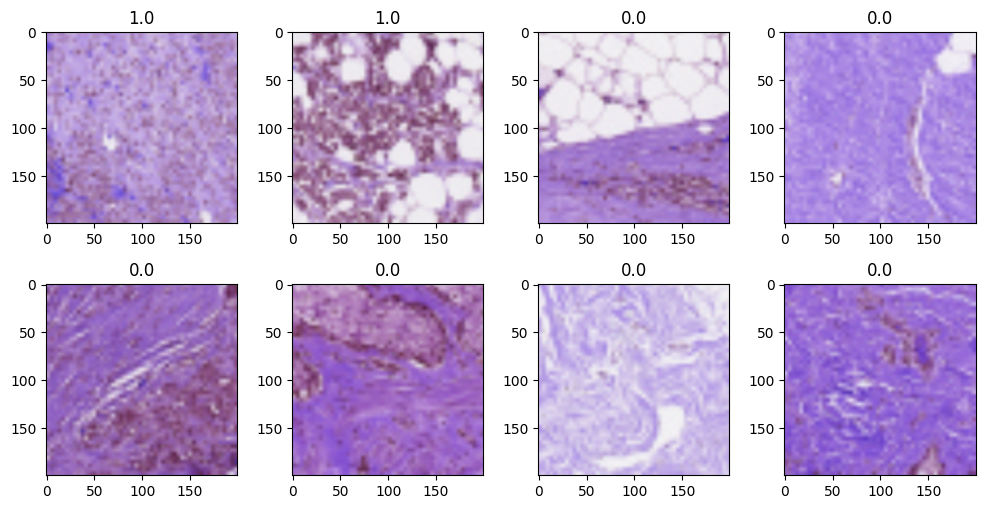

In [24]:
# Visualization

for img_batch, label_batch in valid_set_small.take(1):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(img_batch)):
        ax = fig.add_subplot(4, 4, i+1)
        ax.imshow(img_batch[i].numpy().astype('int'))
        ax.set_title(label_batch[i].numpy())
plt.tight_layout()

### Create Model

In [25]:
model = tf.keras.models.Sequential([
    layers.InputLayer(input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3]), 
    layers.RandomRotation(0.2), 
    layers.RandomZoom(0.15), 
    layers.RandomFlip('horizontal'), 

    layers.Conv2D(32, 3, activation='relu', padding='same'), 
    layers.Conv2D(32, 3, activation='relu', padding='same'), 
    layers.MaxPooling2D(2), 
    layers.BatchNormalization(), 

    layers.Conv2D(64, 3, activation='relu', padding='same'), 
    layers.Conv2D(64, 3, activation='relu', padding='same'), 
    layers.MaxPooling2D(2), 
    layers.BatchNormalization(), 

    layers.Conv2D(128, 3, activation='relu', padding='same'), 
    layers.Conv2D(128, 3, activation='relu', padding='same'), 
    layers.MaxPooling2D(2), 
    layers.BatchNormalization(), 

    layers.Conv2D(256, 3, activation='relu', padding='same'), 
    layers.Conv2D(256, 3, activation='relu', padding='same'), 
    layers.MaxPooling2D(2), 
    layers.BatchNormalization(), 

    layers.Conv2D(512, 3, activation='relu', padding='same'), 
    layers.Conv2D(512, 3, activation='relu', padding='same'), 
    layers.MaxPooling2D(2), 
    layers.BatchNormalization(), 

    layers.Flatten(), 
    layers.Dense(32, activation='relu'), 
    layers.BatchNormalization(), 
    layers.Dropout(0.4), 
    layers.Dense(1, activation='sigmoid')
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 200, 200, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 200, 200, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                      

In [27]:
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=[
        tf.keras.metrics.BinaryAccuracy(), 
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall(), 
        tf.keras.metrics.AUC()
    ]
)

In [28]:
# Create Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5), 
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_custom.h5', 
                                       save_best_only=True)
]

In [29]:
# Train the model
history = model.fit(
    train_set_small, 
    validation_data=valid_set_small, 
    callbacks=callbacks, 
    epochs=20, 
    class_weight={0:1, 1:3}
)

Epoch 1/20
2025/2025 [==============================] - 107s 44ms/step - loss: 0.8972 - binary_accuracy: 0.7154 - precision: 0.5082 - recall: 0.7754 - auc: 0.7951 - val_loss: 0.5744 - val_binary_accuracy: 0.7431 - val_precision: 0.8625 - val_recall: 0.1326 - val_auc: 0.8720
Epoch 2/20
2025/2025 [==============================] - 91s 45ms/step - loss: 0.7537 - binary_accuracy: 0.7643 - precision: 0.5662 - recall: 0.8228 - auc: 0.8527 - val_loss: 0.9545 - val_binary_accuracy: 0.7096 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7188
Epoch 3/20
2025/2025 [==============================] - 91s 45ms/step - loss: 0.7119 - binary_accuracy: 0.7783 - precision: 0.5832 - recall: 0.8431 - auc: 0.8700 - val_loss: 0.4059 - val_binary_accuracy: 0.8372 - val_precision: 0.7639 - val_recall: 0.6323 - val_auc: 0.8689
Epoch 4/20
2025/2025 [==============================] - 90s 45ms/step - loss: 0.6986 - binary_accuracy: 0.7833 - precision: 0.5897 - recall: 0.8467 - auc: 0.8754 - val_l

<Axes: >

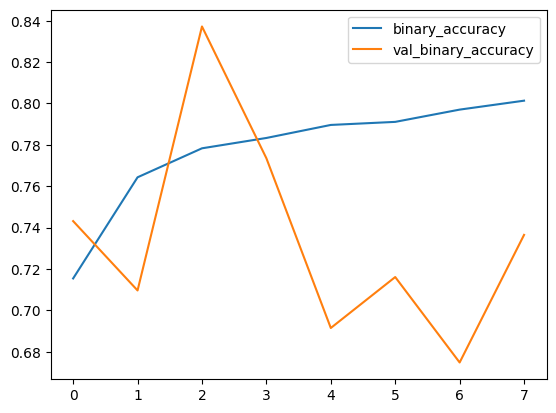

In [30]:
# Plot the training
pd.DataFrame(history.history)[['binary_accuracy', 'val_binary_accuracy']].plot()

<Axes: >

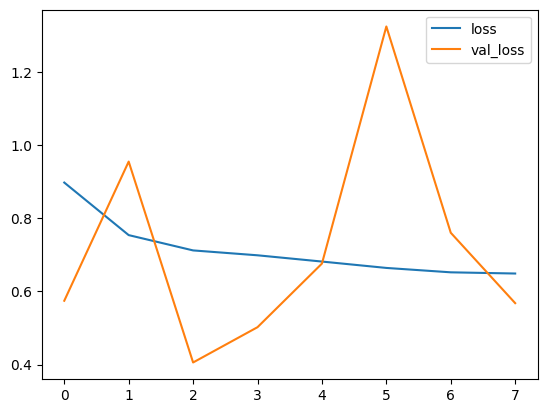

In [31]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

### Evaluate the model

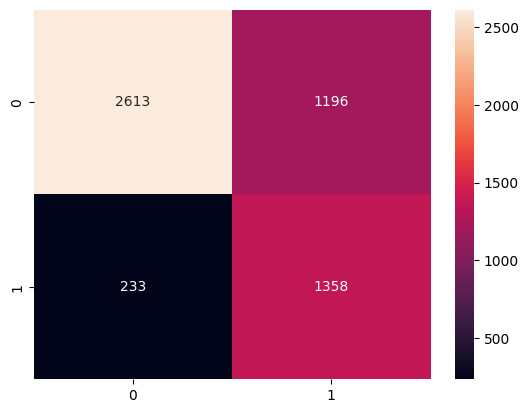

              precision    recall  f1-score   support

         0.0       0.92      0.69      0.79      3809
         1.0       0.53      0.85      0.66      1591

    accuracy                           0.74      5400
   macro avg       0.72      0.77      0.72      5400
weighted avg       0.80      0.74      0.75      5400



In [32]:
# Instantiate empty NumPy array
y_pred = np.array([])
y_true = np.array([])
count = 0

for x, y in test_set_small:
    print(f'Evaluating batch {count}/{len(test_set_small)}', end='\r')
    count += 1
    y_pred = np.concatenate([y_pred, model(x).numpy().flatten()])
    y_true = np.concatenate([y_true, y.numpy()])

sns.heatmap(confusion_matrix(y_true, np.round(y_pred)), annot=True, fmt='g')
plt.show()

print(classification_report(y_true, np.round(y_pred)))

### Build an EfficientNet model

In [33]:
model_efficientnet = tf.keras.models.Sequential([
    layers.InputLayer(input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3]), 
    layers.RandomRotation(0.2), 
    layers.RandomZoom(0.15), 
    layers.RandomFlip('horizontal'), 
    tf.keras.applications.EfficientNetV2S(weights='imagenet', include_top=False), 
    layers.GlobalAveragePooling2D(), 
    layers.Dropout(0.3), 
    layers.Dense(1, activation='sigmoid')
])

model_efficientnet.summary()

82420632/82420632 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomRo  (None, 200, 200, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 200, 200, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 200, 200, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                

In [34]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5), 
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_efficientnetv2s.h5', 
                                       save_best_only=True)
]

In [35]:
model_efficientnet.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=[
        tf.keras.metrics.BinaryAccuracy(), 
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall(), 
        tf.keras.metrics.AUC()
    ]
)

In [36]:
history_efficient = model_efficientnet.fit(
    train_set_small, 
    validation_data=valid_set_small, 
    callbacks=callbacks, 
    epochs=20, 
    class_weight={0:1, 1:3}
)

Epoch 1/20
2025/2025 [==============================] - 377s 146ms/step - loss: 0.6590 - binary_accuracy: 0.8010 - precision_1: 0.6140 - recall_1: 0.8570 - auc_1: 0.8915 - val_loss: 0.3418 - val_binary_accuracy: 0.8631 - val_precision_1: 0.6987 - val_recall_1: 0.9257 - val_auc_1: 0.9467
Epoch 2/20
2025/2025 [==============================] - 290s 143ms/step - loss: 0.5725 - binary_accuracy: 0.8322 - precision_1: 0.6588 - recall_1: 0.8820 - auc_1: 0.9169 - val_loss: 0.3708 - val_binary_accuracy: 0.8241 - val_precision_1: 0.6290 - val_recall_1: 0.9545 - val_auc_1: 0.9465
Epoch 3/20
2025/2025 [==============================] - 291s 144ms/step - loss: 0.5472 - binary_accuracy: 0.8401 - precision_1: 0.6701 - recall_1: 0.8904 - auc_1: 0.9238 - val_loss: 0.3283 - val_binary_accuracy: 0.8602 - val_precision_1: 0.6883 - val_recall_1: 0.9436 - val_auc_1: 0.9561
Epoch 4/20
2025/2025 [==============================] - 292s 144ms/step - loss: 0.5243 - binary_accuracy: 0.8485 - precision_1: 0.6841 -

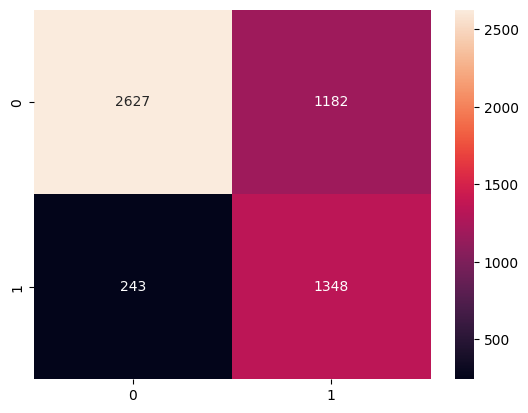

              precision    recall  f1-score   support

         0.0       0.92      0.69      0.79      3809
         1.0       0.53      0.85      0.65      1591

    accuracy                           0.74      5400
   macro avg       0.72      0.77      0.72      5400
weighted avg       0.80      0.74      0.75      5400



In [37]:
# Evaluate the Model
# Instantiate empty NumPy array
y_pred = np.array([])
y_true = np.array([])
count = 0

for x, y in test_set_small:
    print(f'Evaluating batch {count}/{len(test_set_small)}', end='\r')
    count += 1
    y_pred = np.concatenate([y_pred, model(x).numpy().flatten()])
    y_true = np.concatenate([y_true, y.numpy()])

sns.heatmap(confusion_matrix(y_true, np.round(y_pred)), annot=True, fmt='g')
plt.show()

print(classification_report(y_true, np.round(y_pred)))

### Build Resnet Model

In [38]:
# Build model
model_resnet = tf.keras.models.Sequential([
    layers.InputLayer(input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3]), 
    layers.RandomRotation(0.2), 
    layers.RandomZoom(0.15), 
    layers.RandomFlip('horizontal'), 
    tf.keras.applications.ResNet101(weights='imagenet', include_top=False), 
    layers.GlobalAveragePooling2D(), 
    layers.Dense(1, activation='sigmoid')
])

171446536/171446536 [==============================] - 8s 0us/step


In [39]:
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_2 (RandomRo  (None, 200, 200, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 200, 200, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 200, 200, 3)       0         
                                                                 
 resnet101 (Functional)      (None, None, None, 2048)  42658176  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                

In [40]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5), 
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_resnet101.h5', 
                                       save_best_only=True)
]

In [41]:
# Compile the model
model_resnet.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=[
        tf.keras.metrics.BinaryAccuracy(), 
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall(), 
        tf.keras.metrics.AUC()
    ]
)

In [42]:
# Fit the model
history_resnet = model_resnet.fit(
    train_set_small, 
    validation_data=valid_set_small, 
    callbacks=callbacks, 
    epochs=20, 
    class_weight={0:1, 1:3}
)

Epoch 1/20
2025/2025 [==============================] - 429s 178ms/step - loss: 0.8825 - binary_accuracy: 0.7067 - precision_2: 0.4985 - recall_2: 0.8069 - auc_2: 0.8129 - val_loss: 0.9100 - val_binary_accuracy: 0.6276 - val_precision_2: 0.4348 - val_recall_2: 0.9616 - val_auc_2: 0.8871
Epoch 2/20
2025/2025 [==============================] - 360s 178ms/step - loss: 0.7280 - binary_accuracy: 0.7818 - precision_2: 0.5908 - recall_2: 0.8213 - auc_2: 0.8654 - val_loss: 0.6671 - val_binary_accuracy: 0.7106 - val_precision_2: 0.4444 - val_recall_2: 0.0051 - val_auc_2: 0.7926
Epoch 3/20
2025/2025 [==============================] - 359s 177ms/step - loss: 0.7311 - binary_accuracy: 0.7836 - precision_2: 0.5940 - recall_2: 0.8168 - auc_2: 0.8639 - val_loss: 0.5710 - val_binary_accuracy: 0.8057 - val_precision_2: 0.6997 - val_recall_2: 0.5746 - val_auc_2: 0.8472
Epoch 4/20
2025/2025 [==============================] - 359s 177ms/step - loss: 0.6346 - binary_accuracy: 0.8113 - precision_2: 0.6316 -

### Build Xception model

In [43]:
# Build the model
model_xception = tf.keras.models.Sequential([
    layers.InputLayer(input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3]), 
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15), 
    layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.applications.Xception(weights='imagenet', include_top=False), 
    layers.GlobalAveragePooling2D(), 
    layers.Dense(1, activation='sigmoid') 
])

83683744/83683744 [==============================] - 5s 0us/step


In [44]:
model_xception.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_3 (RandomRo  (None, 200, 200, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 200, 200, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 200, 200, 3)       0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1)                

In [45]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5), 
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_xception.h5', 
                                       save_best_only=True)
]

In [46]:
# Compile the model
model_xception.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=[
        tf.keras.metrics.BinaryAccuracy(), 
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall(), 
        tf.keras.metrics.AUC()
    ]
)

In [47]:
# Fit the model
history_xception = model_xception.fit(
    train_set_small, 
    validation_data=valid_set_small, 
    callbacks=callbacks, 
    epochs=20, 
    class_weight={0:1, 1:3}
)

Epoch 1/20
2025/2025 [==============================] - 285s 126ms/step - loss: 0.6700 - binary_accuracy: 0.7968 - precision_3: 0.6081 - recall_3: 0.8541 - auc_3: 0.8867 - val_loss: 0.6916 - val_binary_accuracy: 0.7344 - val_precision_3: 0.5218 - val_recall_3: 0.9757 - val_auc_3: 0.9367
Epoch 2/20
2025/2025 [==============================] - 253s 125ms/step - loss: 0.5674 - binary_accuracy: 0.8299 - precision_3: 0.6542 - recall_3: 0.8849 - auc_3: 0.9183 - val_loss: 0.8830 - val_binary_accuracy: 0.8119 - val_precision_3: 0.6852 - val_recall_3: 0.6457 - val_auc_3: 0.7520
Epoch 3/20
2025/2025 [==============================] - 252s 125ms/step - loss: 0.5458 - binary_accuracy: 0.8436 - precision_3: 0.6770 - recall_3: 0.8879 - auc_3: 0.9244 - val_loss: 1.9641 - val_binary_accuracy: 0.8235 - val_precision_3: 0.6585 - val_recall_3: 0.8091 - val_auc_3: 0.8585
Epoch 4/20
2025/2025 [==============================] - 253s 125ms/step - loss: 0.5143 - binary_accuracy: 0.8530 - precision_3: 0.6931 -

### Model Comparison

In [48]:
preds_base = model.evaluate(test_set_small)
preds_efficentnet = model_efficientnet.evaluate(test_set_small)
preds_resnet = model_resnet.evaluate(test_set_small)
preds_xception = model_xception.evaluate(test_set_small)

# Extract relevant model-related values
base_recall, base_precision, base_auc, base_params = preds_base[3], preds_base[2], preds_base[4], model.count_params()
efficientnet_recall, efficientnet_precision, efficientnet_auc, efficientnet_params = preds_efficentnet[3], preds_efficentnet[2], preds_efficentnet[4], model_efficientnet.count_params()
resnet_recall, resnet_precision, resnet_auc, resnet_params = preds_resnet[3], preds_resnet[2], preds_resnet[4], model_resnet.count_params()
xception_recall, xception_precision, xception_auc, xception_params = preds_xception[3], preds_xception[2], preds_xception[4], model_xception.count_params()

# Create dictionary

model_metrics = {
    'Base_model' : [base_recall, base_precision, base_auc, base_params], 
    'EfficientNet': [efficientnet_recall, efficientnet_precision, efficientnet_auc, efficientnet_params], 
    'ResNet101': [resnet_recall, resnet_precision, resnet_auc, resnet_params], 
    'Xception': [xception_recall, xception_precision, xception_auc, xception_params]
}

# Dict to dataframe
model_metrics_df = pd.DataFrame(model_metrics, index=['Recall', 'Precision', 'AUC', 'Model Parameters']).T

model_metrics_df.head()

675/675 [==============================] - 20s 30ms/step - loss: 0.2945 - binary_accuracy: 0.8850 - precision_3: 0.7303 - recall_3: 0.9667 - auc_3: 0.9705


,Recall,Precision,AUC,Model Parameters
Base_model,0.856694,0.531384,0.851152,5306209.0
EfficientNet,0.919547,0.775305,0.956673,20332641.0
ResNet101,0.825267,0.784349,0.937773,42660225.0
Xception,0.966688,0.730294,0.970494,20863529.0


In [ ]:
# Plot
model_metrics_df_plot = model_metrics_df[['Recall', 'Precision', 'AUC']]
fig, ax = plt.subplots(figsize=(12, 8))

df_bar = model_metrics_df_plot.reset_index().melt(id_vars=['index'])
sns.barplot(x='variable', y='value', hue='index', data=df_bar, ax=ax)

### Hyperparamter Tuning

In [50]:
# Write a function to Build a model(EfficientNet) with open hyperparameters
def build_efficientNet(hp):
    # Build model
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3]), 
        layers.RandomRotation(hp.Choice('random_rot', [0.10, 0.15, 0.20, 0.3])), 
        layers.RandomZoom(hp.Choice('random_zoom', [0.10, 0.15, 0.20, 0.3])), 
        layers.RandomFlip(hp.Choice('flip', ['horizontal', 'vertical', 'horizontal_and_vertical'])), 
        tf.keras.applications.EfficientNetV2S(weights='imagenet', include_top=False), 
        layers.GlobalAveragePooling2D(), 
        layers.Dropout(hp.Choice('dropout', [0.2, 0.3, 0.4])), 
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        loss='binary_crossentropy', 
        optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'nadam']), 
        metrics=[
            tf.keras.metrics.BinaryAccuracy(), 
            tf.keras.metrics.Precision(), 
            tf.keras.metrics.Recall(), 
            tf.keras.metrics.AUC()
        ]
    )

    return model

In [51]:
# Instantiate Tuner object
tuner = kt.Hyperband(
    build_efficientNet, 
    objective='val_loss', 
    max_epochs=5
)

In [52]:
# Perform the search
tuner.search(
    train_set_small, 
    epochs=5, 
    validation_data=valid_set_small
    )

Trial 10 Complete [00h 34m 38s]
val_loss: 0.23178917169570923

Best val_loss So Far: 0.19311104714870453
Total elapsed time: 02h 54m 18s


In [53]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0008 summary
Hyperparameters:
random_rot: 0.15
random_zoom: 0.15
flip: vertical
dropout: 0.4
optimizer: sgd
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.19311104714870453

Trial 0006 summary
Hyperparameters:
random_rot: 0.1
random_zoom: 0.1
flip: vertical
dropout: 0.4
optimizer: sgd
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0000
Score: 0.20105412602424622

Trial 0007 summary
Hyperparameters:
random_rot: 0.2
random_zoom: 0.3
flip: horizontal
dropout: 0.4
optimizer: sgd
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.20310470461845398

Trial 0005 summary
Hyperparameters:
random_rot: 0.1
random_zoom: 0.1
flip: horizontal_and_vertical
dropout: 0.3
optimizer: sgd
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0003
Score: 0.